In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from math import copysign

In [85]:
## All the funcions:

# EMA formula
def EMA(N, start_index, values):
    if (start_index >= len(values)):
        raise Exception("Index out of bounds!")
    

    multiplier = 0
    divisor = 0
    power = 0
    smoothing = 2 / (N + 1) # Smoothing factor, used in EMA function

    # We iterate over N elements in a reversed direction
    for index in range(start_index, start_index - N, -1):
        if (index < 0):
            break

        multiplier += values[index] * smoothing**power
        divisor += smoothing**power
        power += 1

    return (multiplier/divisor)

# EMA values list for n last elements
def EMA_values(N, n_elements, values):
    size = len(values)

    ema_values = []

    if n_elements > size:
        raise Exception("List length is smaller than number of elements!")
    
    start_index = size - n_elements

    #calculate ema for each element in the "scope"
    for index in range(start_index, size):
        ema_values.append(EMA(N, index, values))

    return ema_values

# MACD = EMA12 - EMA26
def MACD_values(n_elements, values):
    size = len(values)

    macd_values = []

    if n_elements > size:
        raise Exception("List length is smaller than number of elements!")

    ema12_values = EMA_values(12, n_elements, values)
    ema26_values = EMA_values(26, n_elements, values)

    #calculate ema difference for each element in the "scope"
    for index in range(0, n_elements):
        macd_values.append(ema12_values[index] - ema26_values[index])

    return macd_values

# Signal = EMA9 of the MACD values!
def Signal_values(n_elements, macd_values):
    return EMA_values(9, n_elements, macd_values)


# Plot formulas:

# Macd-signal difference
def plot_macd_signal_difference(x_analyzed, macd_signal_difference):
    # Create colors based on the sign of each value:
    colors = ['green' if val >= 0 else 'red' for val in macd_signal_difference]

    # Create the bar plot:
    plt.figure(figsize=(12, 6))
    plt.bar(x_analyzed, macd_signal_difference, color=colors)


    plt.title('MACD - Signal')

<bound method DataFrame.info of             time     Open     High      Low    Close      Volume
0     2021-01-01    1.510    1.865    1.495    1.847  1125773.54
1     2021-01-02    1.847    2.012    1.752    1.799  1060347.35
2     2021-01-03    1.799    2.808    2.007    2.185  1475936.63
3     2021-01-04    2.185    2.573    2.066    2.491  1543191.05
4     2021-01-05    2.491    2.634    2.145    2.158  1246011.66
...          ...      ...      ...      ...      ...         ...
1363  2024-09-25  152.720  153.880  147.300  147.970  1140072.57
1364  2024-09-26  147.970  158.030  146.590  155.580  1590861.37
1365  2024-09-27  155.580  161.240  154.010  157.640  1503547.66
1366  2024-09-28  157.640  159.400  155.080  156.780   576303.31
1367  2024-09-29  156.780  160.770  155.120  160.010   741062.22

[1368 rows x 6 columns]>


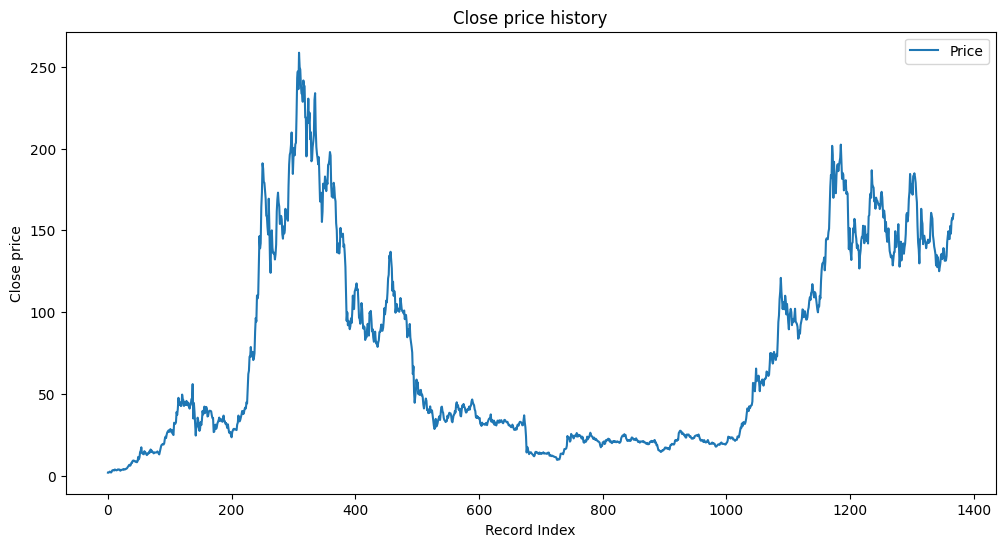

In [86]:
## Main data import and variables creation

data_frame = pd.read_csv("Solana_daily_data_2021_2024.csv")
print(data_frame.info)

close_data = data_frame.get("Close").tolist()   # Price and the end of the day
time_data = data_frame.get("time").tolist()     # Corresponding days

n_records = len(close_data)
n_records_analyzed = 100

x_full = np.arange(n_records)
x_analyzed = np.arange(n_records - n_records_analyzed, n_records)


plt.figure(figsize=(12, 6))

plt.plot(x_full, close_data, label="Price")


plt.xlabel('Record Index')
plt.ylabel('Close price')
plt.title('Close price history')
plt.legend()
plt.show()

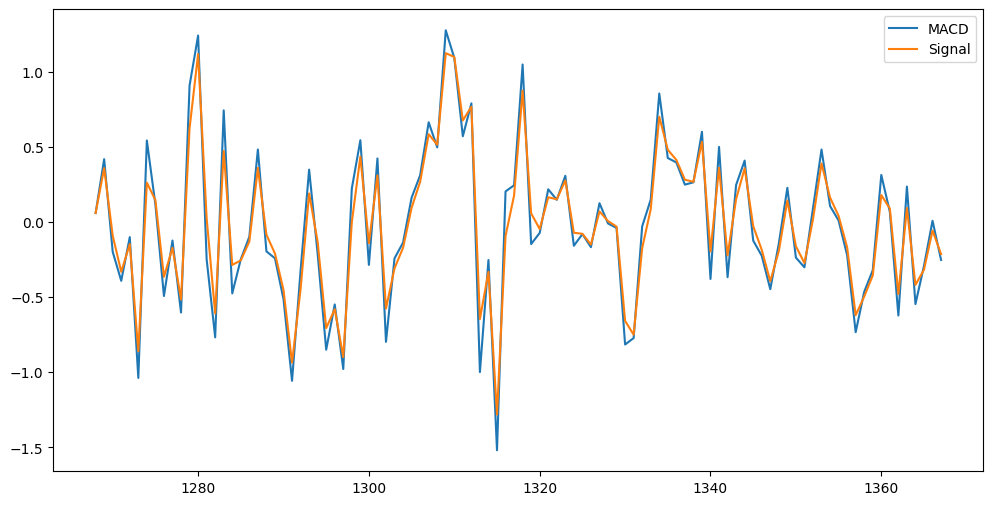

In [87]:
macd_values = MACD_values(n_records_analyzed, close_data)
signal_values = Signal_values(n_records_analyzed, macd_values)


plt.figure(figsize=(12, 6))
plt.plot(x_analyzed, macd_values, label="MACD")
plt.plot(x_analyzed, signal_values, label="Signal")
plt.legend()
plt.show()


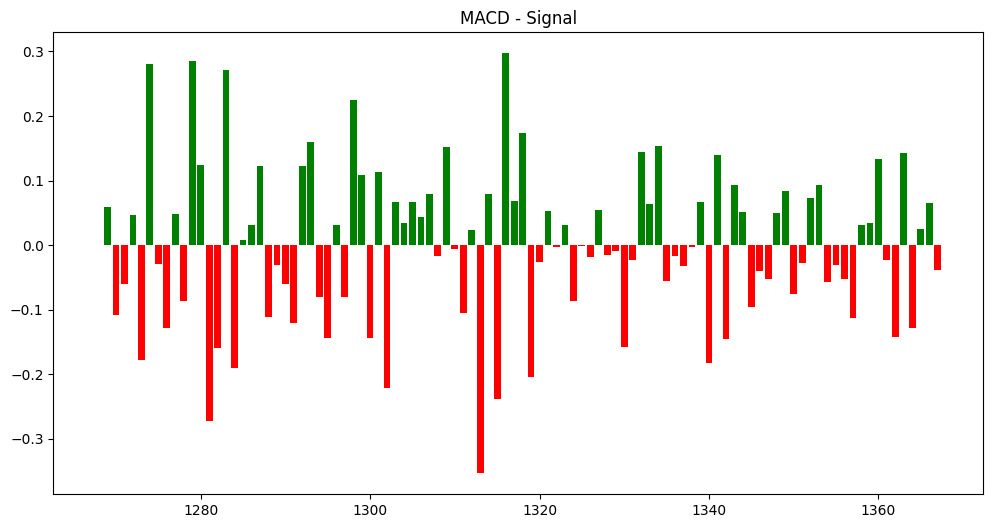

In [88]:
# For transaction decision me are interested in MACD Signal difference 
macd_signal_difference = np.subtract(macd_values, signal_values)

plot_macd_signal_difference(x_analyzed, macd_signal_difference)

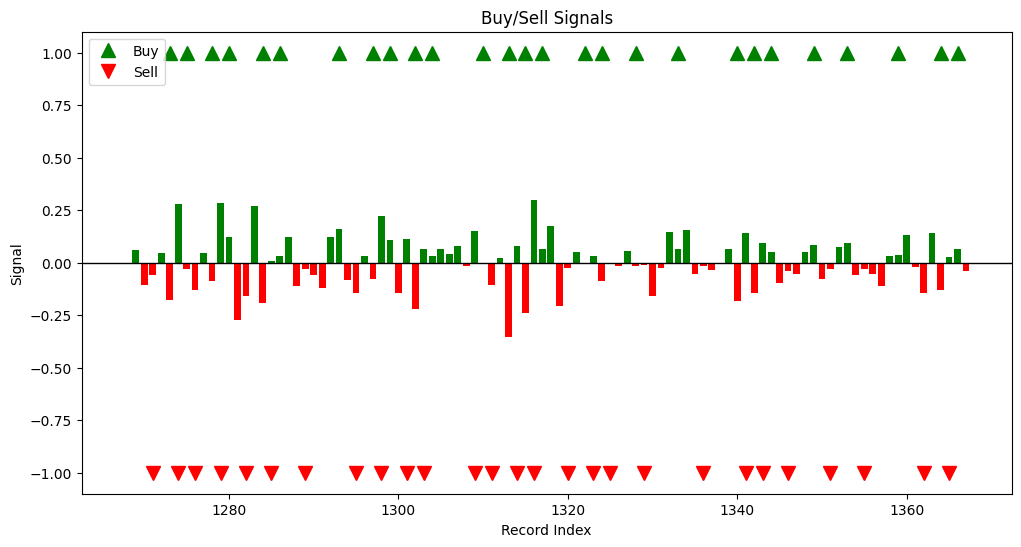

In [89]:
# 0 - nothing, 1 - buy, 2 - sell
transactions = np.zeros(n_records_analyzed)
# 1 - keep, -1 - sell
current_state = 1

## TODO: iterate through 
for index in range(1, n_records_analyzed):
    if copysign(1, macd_signal_difference[index - 1]) != current_state: # if the sign was changed
        if current_state == 1:
            current_state = -1
            transactions[index] = 2 # sell
        else:
            current_state = 1
            transactions[index] = 1 # buy

plot_macd_signal_difference(x_analyzed, macd_signal_difference)

# Get indexes where actions occur
buy_indexes = np.where(transactions == 1)[0] + x_analyzed[0]
sell_indexes = np.where(transactions == 2)[0] + x_analyzed[0]

# For display, assign a y-value for markers. Here we use y=1 for buys and y=-1 for sells.
y_buy = np.ones_like(buy_indexes)
y_sell = -np.ones_like(sell_indexes)

# Create the plot
plt.plot(buy_indexes, y_buy, 'g^', markersize=10, label='Buy')  # green upward triangles for buy
plt.plot(sell_indexes, y_sell, 'rv', markersize=10, label='Sell')  # red downward triangles for sell

# Draw a horizontal line at y=0
plt.axhline(0, color='black', linewidth=1)

plt.xlabel('Record Index')
plt.ylabel('Signal')
plt.title('Buy/Sell Signals')
plt.legend()